In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import pypsa
import pandas as pd
import numpy as np

plt.style.use(["bmh", "../../matplotlibrc"])
sns.set_palette("colorblind")

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 100

In [8]:
files = {
    "perfectly\ninelastic": "../../results/20240424-70a/network_solved_LT-country+DE-inelastic+true.nc",
    "VOLL\n2000 €/MWh": "../../results/20240424-70a/network_solved_LT-country+DE-voll+true.nc",
    "PWL-elastic\ndefault": "../../results/20240424-70a/network_solved_LT-country+DE-elastic_pwl+default.nc",
    "PWL-elastic\nhigh": "../../results/20240424-70a/network_solved_LT-country+DE-elastic_pwl+higher.nc",
    "PWL-elastic\nlow": "../../results/20240424-70a/network_solved_LT-country+DE-elastic_pwl+lower.nc",
}
ns = {k: pypsa.Network(v) for k, v in files.items()}

INFO:pypsa.io:Imported network network_solved_LT-country+DE-inelastic+true.nc has buses, carriers, generators, links, loads, stores
INFO:pypsa.io:Imported network network_solved_LT-country+DE-voll+true.nc has buses, carriers, generators, links, stores
INFO:pypsa.io:Imported network network_solved_LT-country+DE-elastic_pwl+default.nc has buses, carriers, generators, links, loads, stores
INFO:pypsa.io:Imported network network_solved_LT-country+DE-elastic_pwl+higher.nc has buses, carriers, generators, links, loads, stores
INFO:pypsa.io:Imported network network_solved_LT-country+DE-elastic_pwl+lower.nc has buses, carriers, generators, links, loads, stores


In [9]:
fn = "../../data/time_series_60min_singleindex_filtered-2019-06-05.csv"
opsd = pd.read_csv(fn, parse_dates=True, index_col=0)
fn = "../../data/time_series_60min_singleindex_filtered-2020-10-06.csv"
opsd_supplement = pd.read_csv(fn, parse_dates=True, index_col=0)
opsd = opsd.reindex(index=opsd.index.union(opsd_supplement.index))
opsd["DE_LU_price_day_ahead"] = opsd["DE_LU_price_day_ahead"].combine_first(opsd_supplement["DE_LU_price_day_ahead"])
opsd = opsd["DE_price_day_ahead"].combine_first(opsd["DE_AT_LU_price_day_ahead"]).combine_first(opsd["DE_LU_price_day_ahead"])

fns = [
    "../../data/Day-ahead Prices_202001010000-202101010000.csv",
    "../../data/Day-ahead Prices_202101010000-202201010000.csv",
    "../../data/Day-ahead Prices_202201010000-202301010000.csv",
    "../../data/Day-ahead Prices_202301010000-202401010000.csv",
    "../../data/Day-ahead Prices_202401010000-202501010000.csv",
]
entsoe = []
for fn in fns:
    s = pd.read_csv(fn, delimiter=",", skipinitialspace=True, index_col=0, na_values="-")["Day-ahead Price [EUR/MWh]"].dropna()
    s.index = pd.to_datetime(s.index.str.split(' - ').str[0], format='%d.%m.%Y %H:%M').tz_localize("Europe/Berlin", nonexistent='shift_forward', ambiguous='NaT').tz_convert('UTC')
    entsoe.append(s)

entsoe = pd.concat(entsoe)
entsoe = entsoe[~entsoe.index.isna()].dropna()

history = pd.concat([opsd, entsoe])
history = history[~history.index.duplicated(keep='first')]

In [10]:
def get_annual_mean_lmp(n):
    lmp = n.buses_t.marginal_price["electricity"]
    return lmp.groupby(lmp.index.year).mean()

In [11]:
lmp = pd.DataFrame({k: get_annual_mean_lmp(v) for k, v in ns.items()})

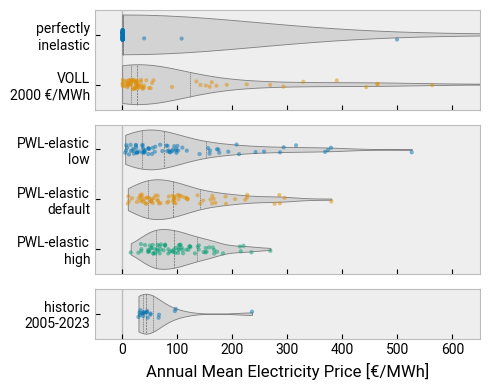

In [13]:
pu_colors = sns.color_palette("rocket", 5)
cat_colors = sns.color_palette("colorblind")

fig, axs = plt.subplots(3, 1, height_ratios=[2, 3, 1], figsize=(5, 4), sharex=True)

sets = [
    ["perfectly\ninelastic", "VOLL\n2000 €/MWh"],
    ["PWL-elastic\nlow", "PWL-elastic\ndefault", "PWL-elastic\nhigh"],
]

violin_kwargs = dict(
    orient="h",
    facecolor="lightgrey",
    edgecolor="grey",
    inner="quart",
    cut=0,
)
for i, s in enumerate(sets):
    sns.stripplot(lmp[s], ax=axs[i], orient="h", alpha=0.5, size=3)
    sns.violinplot(lmp[s], ax=axs[i], **violin_kwargs)

history_lmp = pd.DataFrame({"historic\n2005-2023": history.groupby(history.index.year).mean()})
sns.stripplot(history_lmp, ax=axs[2], orient="h", alpha=0.5, size=3)
sns.violinplot(history_lmp, ax=axs[2], **violin_kwargs)

for ax in axs:
    ax.axvline(0, color="#bbb", lw=1, zorder=0)

plt.xlabel("Annual Mean Electricity Price [€/MWh]")
plt.xlim(-50, 650)

for ext in ["png", "pdf"]:
    plt.savefig(f"../../resources/figure-boxplots.{ext}", bbox_inches='tight', dpi=300)